In [14]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
import ast
import models

In [15]:
df = pd.read_csv('results/auc_analysis.csv')
df2 = pd.read_csv('results/auc_analysis_other_methods.csv')
df3 = pd.read_csv('results/convnet_aucs.csv')

df = df3
df2 = df3

In [16]:
df.iloc[0].ratio

'(1, 1)'

In [17]:
df2.head(100)

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,...,9,10,11,12,13,cap,mean_40,variance_40,mean_50,variance_50
0,normal,2.0,"(0, 1)","(1, 1)",0.0001,0.494733,0.018198,0.750918,4.640585e-03,0.813826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,normal,2.0,"(0, 1)","(1, 1)",1e-05,0.519743,0.006264,0.597883,9.890738e-03,0.606114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ratio,2.0,"(0, 1)","(10, 1)",0.0001,0.497501,0.006026,0.690264,7.467605e-03,0.770731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ratio,2.0,"(0, 1)","(10, 1)",1e-05,0.529497,0.021425,0.490358,1.085149e-02,0.507227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,oversampled,2.0,"(0, 1)","(10, 1)",0.0001,0.514813,0.006777,0.625819,1.382702e-02,0.658846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,triplet_loss,2.0,"(0, 1)","(1, 1)","(1e-07, 0.1)",0.529410,0.005172,0.499750,6.250000e-08,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500250,6.250000e-08,0.500250,6.250000e-08
89,triplet_loss,2.0,"(0, 1)","(1, 1)","(1e-07, 0.01)",0.387674,0.000013,0.500250,6.262506e-08,0.499500,...,NaN,NaN,NaN,NaN,NaN,NaN,0.498503,9.960040e-07,0.498503,2.242506e-06
90,cosine_distance_capped_smote,2.0,"(0, 1)","(100, 1)",0.001,0.506705,0.015783,0.846701,4.700920e-04,0.858489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,cosine_distance_capped_smote,2.0,"(0, 1)","(100, 1)",0.0001,0.482565,0.007310,0.714661,1.416130e-02,0.741452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.ratio = df.ratio.apply(lambda x : ast.literal_eval(x))
df.classes_used = df.classes_used.apply(lambda x : ast.literal_eval(x))
df2.ratio = df2.ratio.apply(lambda x : ast.literal_eval(x))
df2.classes_used = df2.classes_used.apply(lambda x : ast.literal_eval(x))
df3.ratio = df3.ratio.apply(lambda x : ast.literal_eval(x))
df3.classes_used = df3.classes_used.apply(lambda x : ast.literal_eval(x))

ValueError: malformed node or string: (1, 1)

In [19]:
# To-do: 
# loss + gradient descent 
# effective # of samples - implement + read again
# retrain w/ new learning rates 
# 2 class normal - 1e-05 - 1e-06
# 3 class results - for each class
# image augmentations? 
# try smote with MNIST 
# smote from Github 
# add focal loss and SMOTE to graphs 
# CNNs? 

# capping loss for SMOTE 

# choosing examples for SMOTE 

# focal loss + SMOTE (+ parameter updates) (less weight to synthetic examples)
    # utilize a new label - is it synthetically generated or original image 
    # how much to utilize this 
        # synthetic label correctness? 
    # changes to loss function or gradient descent to optimize learning 
    # neural network architecture? w/ embeddings and final output 
        # SMOTE on embeddings 
    # gradient updates - review current methods (Momentum, Adam) 
# loss + tune and train set accuracy every epoch to see if parameter helped 
    # what direction are examples causing weights to move 

# Done:
# 10 : 1 
# focal loss - read + implement (need to check if it works)
# try new plots - best lr? 
# smote - implement (still need to check)

# CNNs on CIFAR10 (and MNIST?) 
    # finish 3 class 
    # compare data 
    
# capping loss for SMOTE on logistic regression 



# Roadmap:

# capping loss on CNNs test 

# embeddings (2nd to last layer) + SMOTE 
    # SMOTE + capped loss with embeddings (euclidian or cosine distance) 
        # greater distance = smaller cap
            # sigmoid
        # beginning will be rlly bad, do something there (triplet/less cap)
    # triplet loss w/ SMOTE 
        # linear probing
    # combined loss function w embeddings (unsupervised learning) and final output (supervised) 
    

# lookahead feature 
    # with smote (or anything) - weight updates 
    # downweight examples 

    


    
ratio = (100,1)

NUM_CLASSES= len(ratio)

normal_df = df.loc[(df.name=='normal') & (df.num_classes==NUM_CLASSES)]
ratio_df = df.loc[(df.name=='ratio') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
oversampled_df = df.loc[(df.name=='oversampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
weighted_df = df.loc[(df.name=='weighted') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
undersampled_df = df.loc[(df.name=='undersampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
bothsampled_df = df.loc[(df.name=='both_sampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]

smote_df = df2.loc[(df2.name=='smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]


capped_smote_df10 = df2.loc[(df2.name=='capped_smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio) & (df2.cap==10.0)]
capped_smote_df5 = df2.loc[(df2.name=='capped_smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio) & (df2.cap==5.0)]
capped_smote_df1 = df2.loc[(df2.name=='capped_smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio) & (df2.cap==1.0)]

distance_capped_smote_df = df2.loc[(df2.name=='distance_capped_smote_fixed') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]
cosine_distance_capped_smote_df = df2.loc[(df2.name=='cosine_distance_capped_smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]
triplet_loss_df = df2.loc[(df2.name=='triplet_loss') & (df2.num_classes==NUM_CLASSES)]

focalloss_df = df2.loc[(df2.name=='focal_loss') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]
weighted_focalloss_df = df2.loc[(df2.name=='weighted_focal_loss') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]


In [20]:
triplet_loss_df.head()

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,...,9,10,11,12,13,cap,mean_40,variance_40,mean_50,variance_50
80,triplet_loss,2.0,"(0, 1)","(1, 1)","(1e-07, 0.001)",0.593451,0.028871,0.670802,2.935465e-02,0.702567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,triplet_loss,2.0,"(0, 1)","(1, 1)","(1e-07, 0.001)",0.503878,0.000013,0.506757,6.601563e-07,0.507247,...,NaN,NaN,NaN,NaN,NaN,NaN,0.508227,1.677025e-06,0.508227,1.671849e-06
88,triplet_loss,2.0,"(0, 1)","(1, 1)","(1e-07, 0.1)",0.529410,0.005172,0.499750,6.250000e-08,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500250,6.250000e-08,0.500250,6.250000e-08
89,triplet_loss,2.0,"(0, 1)","(1, 1)","(1e-07, 0.01)",0.387674,0.000013,0.500250,6.262506e-08,0.499500,...,NaN,NaN,NaN,NaN,NaN,NaN,0.498503,9.960040e-07,0.498503,2.242506e-06


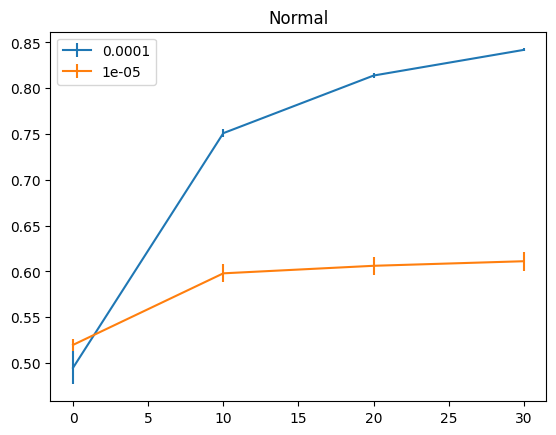

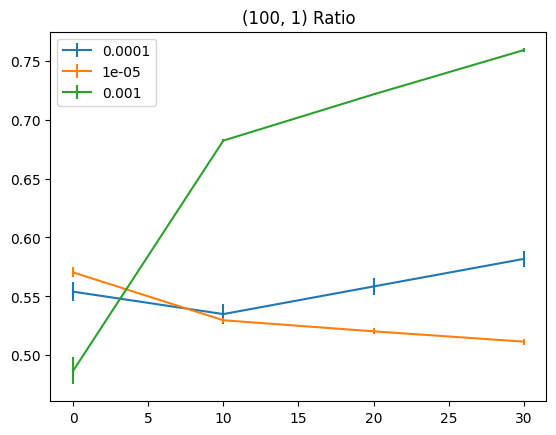

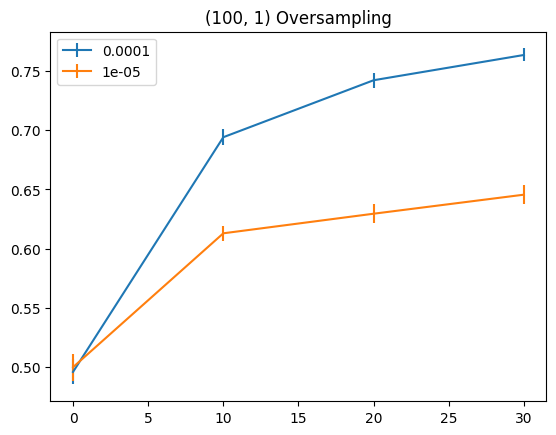

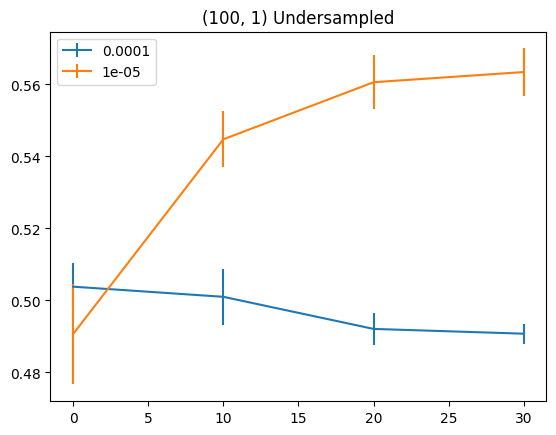

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


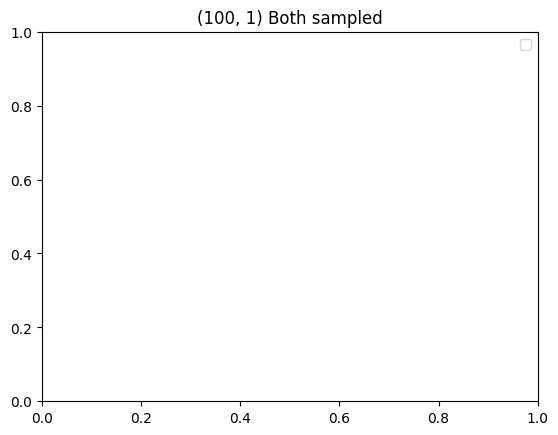

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


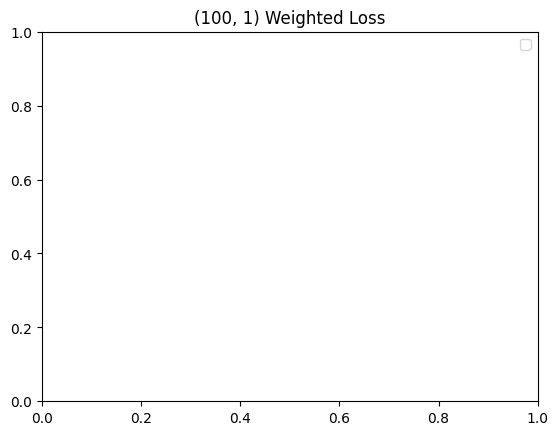

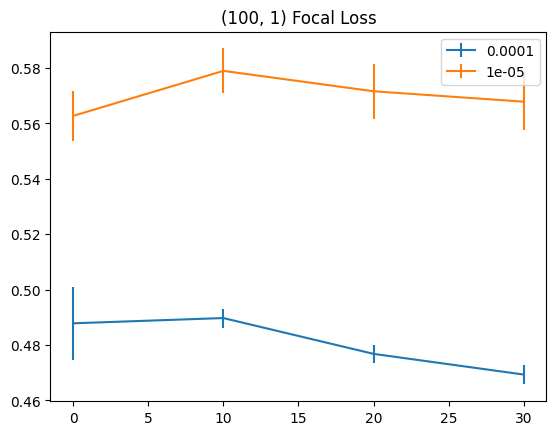

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


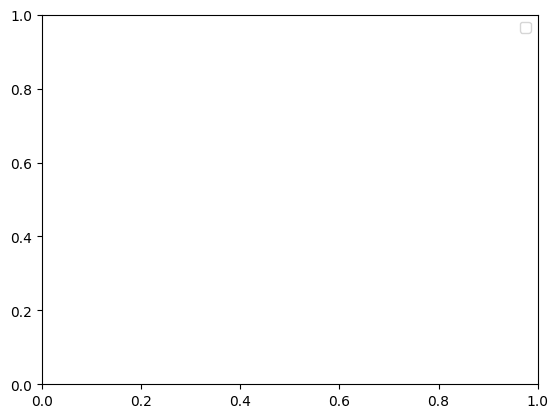

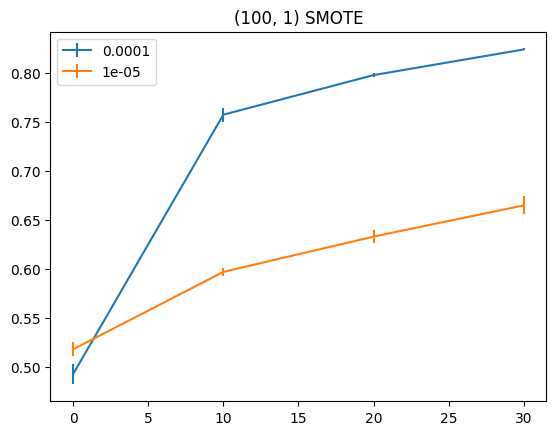

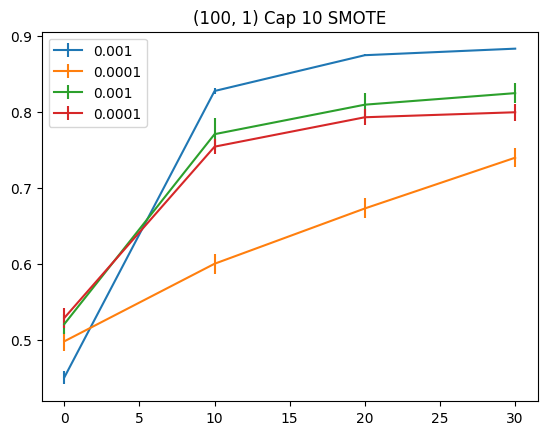

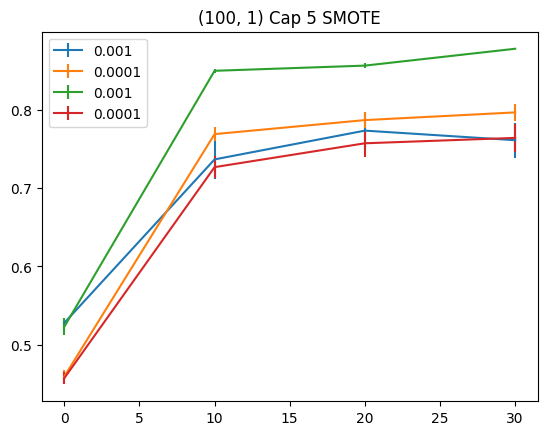

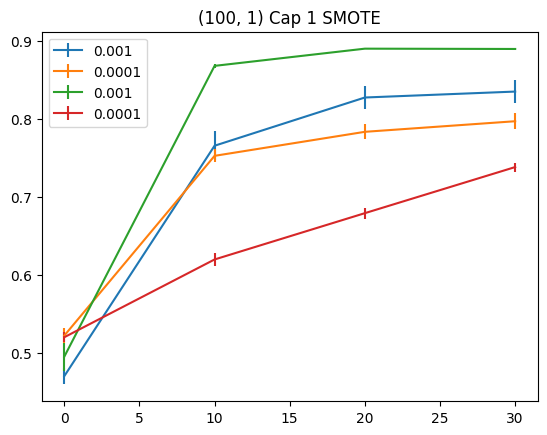

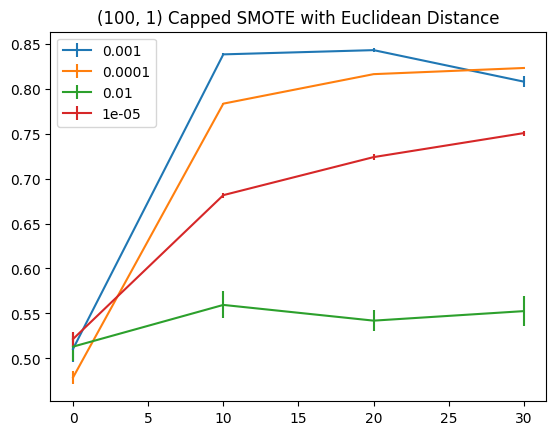

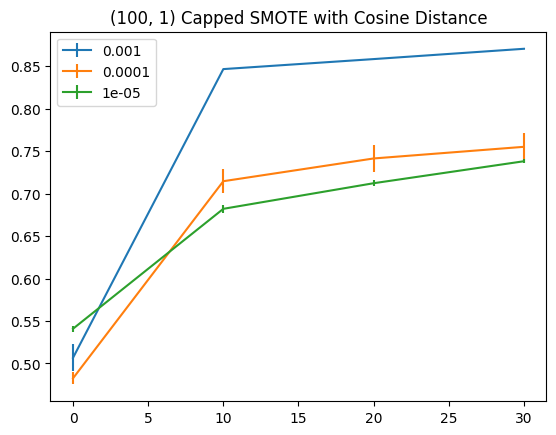

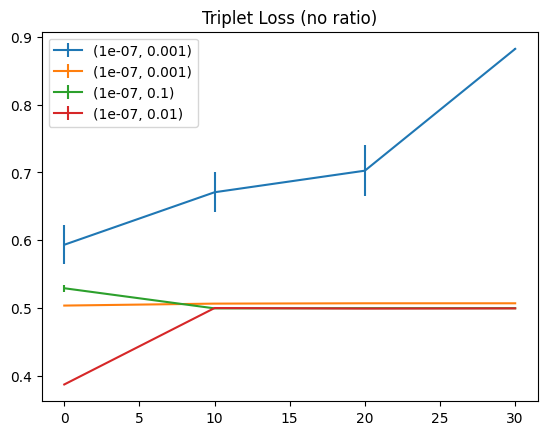

In [21]:
best_lrs={}

epochs = [0, 10, 20, 30]
mean_cols = ["mean_" + str(epoch )for epoch in epochs]
variance_cols = ["variance_" + str(epoch )for epoch in epochs]


best_mean=0
for index, row in normal_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title("Normal")
plt.legend()
plt.show()

best_mean=0
for index, row in ratio_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Ratio")
plt.legend()
plt.show()

best_mean=0
for index, row in oversampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Oversampling")
plt.legend()
plt.show()

best_mean=0
for index, row in undersampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Undersampled")
plt.legend()
plt.show()


best_mean=0
for index, row in bothsampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Both sampled")
plt.legend()
plt.show()

best_mean=0
for index, row in weighted_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Weighted Loss")
plt.legend()
plt.show()

best_mean=0
for index, row in focalloss_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Focal Loss")
plt.legend()
plt.show()

for index, row in weighted_focalloss_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Weighted Focal Loss")
plt.legend()
plt.show()

best_mean=0
for index, row in smote_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " SMOTE")
plt.legend()
plt.show()

best_mean=0
for index, row in capped_smote_df10.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Cap 10 SMOTE")
plt.legend()
plt.show()

best_mean=0
for index, row in capped_smote_df5.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Cap 5 SMOTE")
plt.legend()
plt.show()

best_mean=0
for index, row in capped_smote_df1.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Cap 1 SMOTE")
plt.legend()
plt.show()


best_mean=0
for index, row in distance_capped_smote_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Capped SMOTE with Euclidean Distance")
plt.legend()
plt.show()


best_mean=0
for index, row in cosine_distance_capped_smote_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Capped SMOTE with Cosine Distance")
plt.legend()
plt.show()

best_mean=0
for index, row in triplet_loss_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title("Triplet Loss (no ratio)")
plt.legend()
plt.show()

In [22]:
print(best_lrs)

{'normal': '0.0001', 'ratio': '0.001', 'oversampled': '0.0001', 'undersampled': '1e-05', 'focal_loss': '1e-05', 'smote': '0.0001', 'capped_smote': '0.001', 'distance_capped_smote_fixed': '0.0001', 'cosine_distance_capped_smote': '0.001', 'triplet_loss': '(1e-07, 0.001)'}


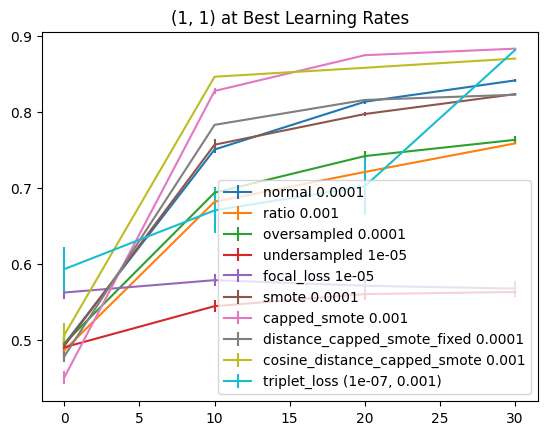

In [23]:
for key in best_lrs:
    means = []
    variances = []
    for epoch in epochs: 
        mean = df.loc[(df.name==key) & (df.num_classes==NUM_CLASSES) & (df.learning_rate==best_lrs[key]) & ((df.ratio==ratio) | (df.ratio==(1, 1)))]['mean_' + str(epoch)].iloc[0]

        var = df.loc[(df.name==key) & (df.num_classes==NUM_CLASSES) & (df.learning_rate==best_lrs[key]) & ((df.ratio==ratio) | (df.ratio==(1, 1)))]['variance_' + str(epoch)].iloc[0]
        means.append(mean)
        variances.append(var)
    plt.errorbar(epochs, means, yerr=variances, label=key + " " + str(best_lrs[key]))
plt.title(str(row['ratio']) + " at Best Learning Rates")
plt.legend()
plt.show()


In [24]:
arr = np.zeros((100, 250, 128))

In [39]:
np.mean(arr, axis=1).shape

(100, 128)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [61]:
ls = [0, 1, 0, 1, 0, 1, 0]
arr = np.array(ls)
print(arr == 0)

[ True False  True False  True False  True]
